This notebook showcases the downsampling scheme I developed in Summer 2017, to make a DESI-like sample. This is done by first abundance matchhing to the GAMA Luminosity function from [Loveday 2015](https://arxiv.org/abs/1505.01003), then downsampling to match what we expect from DESI by matching a catalog made by Song. 

There are a few python packages I use in this notebook that will need to be installed before running. 
* [Yao's code](https://bitbucket.org/yymao/abundancematching) to do the abundance matching. 
* Loading particles from disk requires one of Yao's other packages, [helpers](https://bitbucket.org/yymao/helpers/src). 
* Also, I used [Halotools](https://halotools.readthedocs.io/en/latest/), specifically the halo catalog loading and caching functionalities. 

In [1]:
%reset
from glob import glob
from os import path
import numpy as np
from halotools.sim_manager import CachedHaloCatalog, RockstarHlistReader, UserSuppliedPtclCatalog
from helpers.readGadgetSnapshot import readGadgetSnapshot
from AbundanceMatching import *
import h5py
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from matplotlib import pyplot as plt
%matplotlib notebook

plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.borderpad'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1 
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams.update({'figure.autolayout': True})

# Cache in the catalog

This should read in the big hlist catalog and cut it down to the mass cut & columns we give it. The parameters we will need are the following: 

- filename 
- columns to keep -- the vertical cut  
- cache filename -- where we're going to save the cached cut catalog 
- simulation name 
- halo finder
- redshift 
- version name 
- lbox and particle mass. -- for particle mass Sean has a formula that calculates it **(make sure this work in our case too!)**


In [3]:
# define all the parameters you need to cache in the catalog 
# REMOVE THE CUT FROM THIS CATALOG 

fname = "/Users/eniaxhakaj/data/hlist_0.73330.list"

HLIST_COLS = {'halo_id': (1, 'i8'), 'halo_upid': (6, 'i8'),
              'halo_x': (17, 'f4'), 'halo_y': (18, 'f4'), 'halo_z': (19, 'f4'),
              'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 'halo_vz': (22, 'f4'),
              'halo_mvir': (10, 'f4'), 
              'halo_snapnum': (31, 'i8'),'halo_vpeak':(60, 'f8'), 'halo_halfmass_scale': (61, 'f4'),
              'halo_Acc_Rate_1*Tdyn':(64, "f8"), "halo_Mpeak":(58, "f8")}


columns_to_keep = HLIST_COLS
cache_fname = "/Users/eniaxhakaj/data/hlist_0.73_cache_all.hdf5"
columns_to_convert = []
simname = "smdpl"
halo_finder = "rockstar"
a = 0.84140 # hardcoded from the file name 
redshift = (1. - a)/a
vname = "1." 
Lbox = 1000 
npart = 99994092 # counted how many lines were on the particle file (?)
particle_mass = 1.51e9

In [6]:
# cache in the catalog 

reader = RockstarHlistReader(input_fname=fname, 
                             columns_to_keep_dict=columns_to_keep, 
                             output_fname=cache_fname, 
                             simname=simname, 
                             halo_finder=halo_finder, 
                             redshift=redshift, 
                             version_name=vname, 
                             Lbox=Lbox, 
                             particle_mass=particle_mass,
#                             row_cut_min_dict={"halo_Mpeak":1e12},
                            overwrite=True) 
reader.read_halocat(columns_to_convert_from_kpc_to_mpc=[], write_to_disk = True, update_cache_log = True)

True
False
False
False
False
True
True
False


The information about your ascii file and the metadata about the catalog 
have been processed and no exceptions were raised. 
Use the ``read_halocat`` method to read the ascii data, 
setting the write_to_disk and update_cache_log arguments as you like. 
See the docstring of the ``read_halocat`` method
for details about these options. 


...Processing ASCII data of file: 
/Users/eniaxhakaj/data/hlist_0.73330.list
 
Total number of rows in detected data = 132671827
Number of rows in detected header = 60 

... working on chunk 0 of 186
... working on chunk 1 of 186
... working on chunk 2 of 186
... working on chunk 3 of 186
... working on chunk 4 of 186
... working on chunk 5 of 186
... working on chunk 6 of 186
... working on chunk 7 of 186
... working on chunk 8 of 186
... working on chunk 9 of 186
... working on chunk 10 of 186
... working on chunk 11 of 186
... working on chunk 12 of 186
... working on chunk 13 of 186
... working on chunk

/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/importlib/__init__.py:126: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  return _bootstrap._gcd_import(name[level:], package, level)


False
True
True
True
False
True
False


TypeError: '<' not supported between instances of 'numpy.ndarray' and 'str'

In [4]:
halocat = CachedHaloCatalog(fname=cache_fname, update_cached_fname=True)

False
True
True
True
True
False
True
True
False


In [30]:
halocat.halo_table.colnames

['halo_id',
 'halo_upid',
 'halo_x',
 'halo_y',
 'halo_z',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_mvir',
 'halo_snapnum',
 'halo_vpeak',
 'halo_halfmass_scale',
 'halo_Acc_Rate_1*Tdyn',
 'halo_Mpeak',
 'halo_hostid',
 'halo_mvir_host_halo']

# Cache in and downsample the particles

The downsampling is done in two steps 

(1) Take a subset with replacement from the rows in your table. 

(2) Decrease the size of the sample by 1000 times 

(3) Use the indecces from part 1 and 2 to get the downsampled particles 

# Pair the particle and halo cats 

**What does this exactly do?**

# The luminosity function 

## Done with working code here .... 

Loading up a luminosity function. This one is from GAMA Survey, Loveday 2015. Note the selected redshift ranges. 

In [6]:
lf = np.genfromtxt('lf_r_sersic_z_0.2_0.3.dat', skip_header=True)[:,1:3]
#lf = np.genfromtxt('lf_r_sersic_z_0.1_0.2.dat', skip_header=True)[:,1:3]

In [7]:
lf

array([[-2.388e+01,  3.930e-07],
       [-2.338e+01,  1.870e-06],
       [-2.312e+01,  7.220e-06],
       [-2.288e+01,  1.870e-05],
       [-2.262e+01,  4.100e-05],
       [-2.238e+01,  1.090e-04],
       [-2.212e+01,  2.160e-04],
       [-2.188e+01,  3.880e-04],
       [-2.162e+01,  7.280e-04],
       [-2.138e+01,  1.170e-03],
       [-2.112e+01,  1.800e-03],
       [-2.088e+01,  2.520e-03],
       [-2.062e+01,  3.330e-03],
       [-2.038e+01,  4.200e-03],
       [-2.012e+01,  4.870e-03],
       [-1.988e+01,  6.020e-03],
       [-1.962e+01,  6.580e-03],
       [-1.938e+01,  5.650e-03],
       [-1.912e+01,  1.030e-03],
       [-1.888e+01,  7.840e-05],
       [-1.862e+01,  4.930e-04],
       [-1.838e+01,  2.240e-04],
       [-1.812e+01,  1.750e-04],
       [-1.788e+01,  1.270e-05]])

In [8]:
# apologies for the magic numbers. I tinkered with this particular LF for a while, since the edges get a little 
# noisy. This seemed to give the best extrapolation, but feel free to change. 
use_up_to = -6 
af = AbundanceFunction(lf[:use_up_to,0], lf[:use_up_to,1], (-27, -18),faint_end_fit_points = 7 )

/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


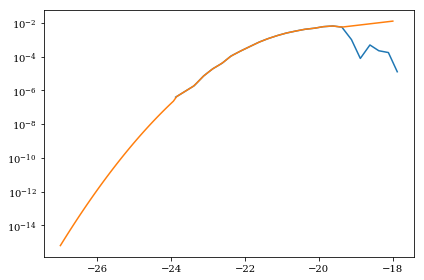

In [9]:
plt.figure()
plt.semilogy(lf[:,0], lf[:,1])
x = np.linspace(-27, -18, 101)
plt.semilogy(x, af(x))

In [10]:
print( max(af(x)))

0.012803895807302974


These checks are reccomended by Yao in his code, linked above.

In [11]:
scatter = 0.2
remainder = af.deconvolute(scatter*LF_SCATTER_MULT, 20)

/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


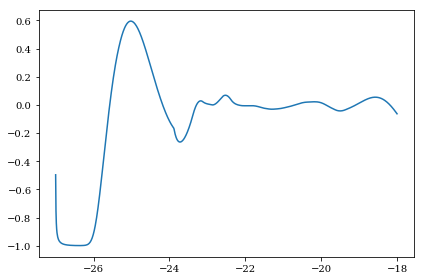

In [12]:
x, nd = af.get_number_density_table()
plt.figure()
plt.plot(x, remainder/nd);

In [13]:
max(nd)

0.020700864155704282

In [14]:
# calculate the number density of our halo proxy
halos = np.array(halocat.halo_table)
    
nd_halos = calc_number_densities(halos['halo_vpeak'], halocat.Lbox[0])

In [15]:
# Do the AB match here. 
full_catalog = af.match(nd_halos, scatter*LF_SCATTER_MULT)

In [16]:
mag_cut = -18 # choose a magitude cut, and make this cut on our sample
valid_idxs = np.logical_and(~np.isnan(full_catalog), full_catalog <= mag_cut)
catalog = full_catalog[valid_idxs]

/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


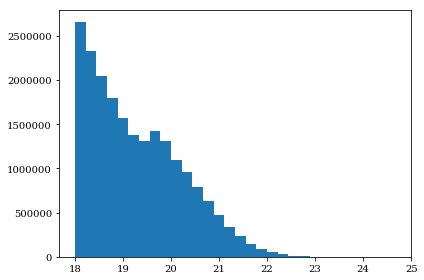

In [17]:
plt.figure()
plt.hist(-1*catalog, bins = 30);

In [18]:
np.savetxt('/Users/eniaxhakaj/Github/desiDeltaSigma/sham_catalog_a_0.3777.npy', catalog) #activate if you want to save the uncut catalog 




We want this plot to approximately match this one from Song. 

In [19]:
song_cat = np.genfromtxt('gama_z0.1_0.3_rband_absmag.ascii')

In [20]:
mags = song_cat[song_cat[:,-1] > -10000,-1 ]

/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


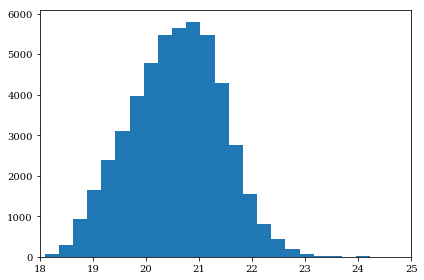

In [21]:
# plt.hist(-1*catalog, bins = 30);
plt.figure()
plt.hist(-1*mags, bins = 30);
plt.xlim([18,25]);

In [22]:
#downsample here
hist, bin_edges = np.histogram(-1*mags, bins = 30)
max_mag= bin_edges[np.argmax(hist)+1]
downsample_idxs = set()
makeshift_hist = []
length = len(hist)

#Index of the bin we want to match to. 
match_idx = -16
low, high = bin_edges[match_idx:match_idx+2]

in_bin_idxs = np.where(np.logical_and(low <= -1*catalog, -1*catalog <= high))[0]

ratio = float(len(in_bin_idxs))/hist[match_idx] #the ratio by which to downsample to. 

#This will print the relative sizes of the bin selected, and its edges. 
print (len(in_bin_idxs), hist[match_idx])
print (low, high)
print (ratio)
#work backwords in bins, from brightest to dimmest and randomly downsample. 
for real_idx, count in enumerate(reversed(hist)):
    idx = length-real_idx-1
    low, high = bin_edges[idx:idx+2]
    
    in_bin_idxs = np.where(np.logical_and(low <= -1*catalog, -1*catalog <= high))[0]

    # if our SHAM has more galaxies then we wanted to downsample to, just leave them all in. 
    # This should only happen in really bright bins
    if in_bin_idxs.shape[0] <= np.ceil(ratio*count):
        sampled_idxs = in_bin_idxs
    else:
        # else, downsample to the correct ratio
        sampled_idxs = np.random.choice(in_bin_idxs, size = int(np.ceil(ratio*count)), replace = False)

    downsample_idxs = downsample_idxs | set(sampled_idxs) #add the downsample idxs to our list
    
downsampled_catalog = catalog[np.array(list(downsample_idxs), dtype=int)]

44282 1559
22.09452019885058 22.36143571093554
28.40410519563823


/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


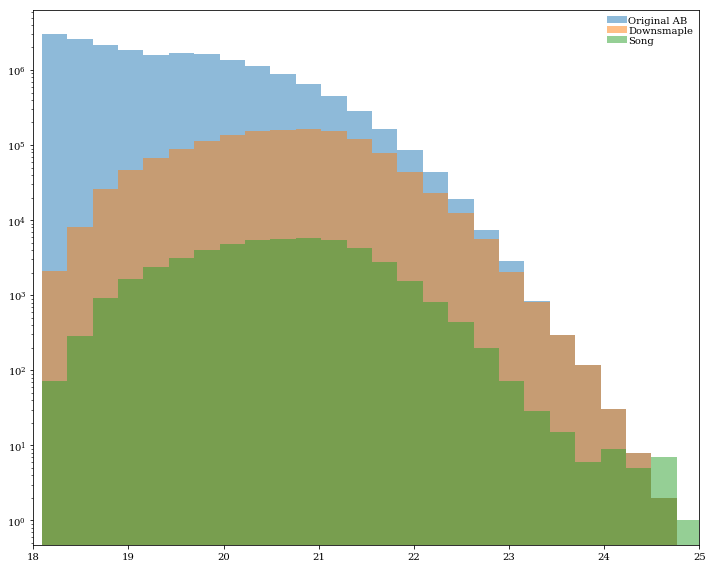

In [23]:
plt.figure(figsize = (10,8))
plt.hist(-1*catalog, bins = bin_edges, label = 'Original AB', alpha = 0.5)
plt.hist(-1*downsampled_catalog, bins = bin_edges, alpha = 0.5, label = "Downsmaple")
plt.hist(-1*mags, bins = bin_edges, alpha = 0.5, label = 'Song');
plt.xlim([18,25]);
plt.legend(loc='best')
plt.yscale('log')
# plt.savefig("/Users/eniaxhakaj/Desktop/downsampling.png")

Yay! It worked. 

/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


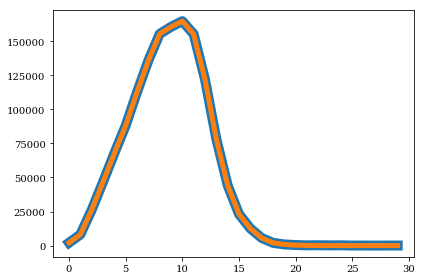

In [24]:
plt.figure()
plt.plot(hist*ratio, lw = 10)
plt.plot(np.histogram(-1*downsampled_catalog, bins = bin_edges)[0], lw = 5)

Yeah! let's save the indexs. 

In [25]:
#put the indicies into an array the size of our original catalog
downsampled_idxs_array = np.zeros_like(valid_idxs, dtype=bool)
counter = 0
for idx, val in enumerate(valid_idxs):
    if val:
        if counter in downsample_idxs:
            downsampled_idxs_array[idx] = True
        counter+=1


downsampled_idxs_array= np.where(valid_idxs)[0][np.array(list(downsample_idxs))]

/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


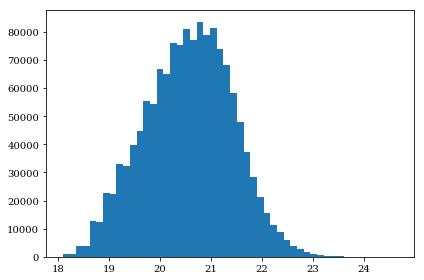

In [26]:
plt.figure()
plt.hist(-1*full_catalog[downsampled_idxs_array], bins = 50);

In [27]:
# save them! 
np.save('gama_matched_catalog_z.36.npy', full_catalog)
np.save('gama_matched_catalog_idxs_z.36.npy', downsampled_idxs_array)

In [28]:
full_catalog[downsampled_idxs_array]

array([-22.82722115, -21.31549862, -21.51820068, ..., -21.50262873,
       -21.42615658, -19.9468374 ])

/Users/eniaxhakaj/miniconda2/envs/astro3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


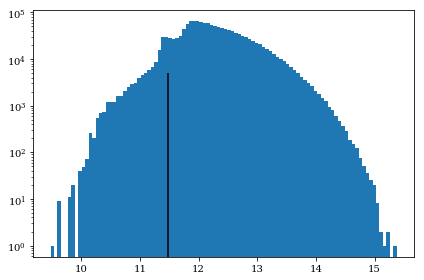

In [29]:
plt.figure()
plt.hist(np.log10(halocat.halo_table[downsampled_idxs_array]['halo_mvir']), bins = 100);
plt.vlines(np.log10(200*halocat.particle_mass), 0, 5e3)
plt.yscale('log')

## Make the plots that Alexie asked you 

<IPython.core.display.Javascript object>


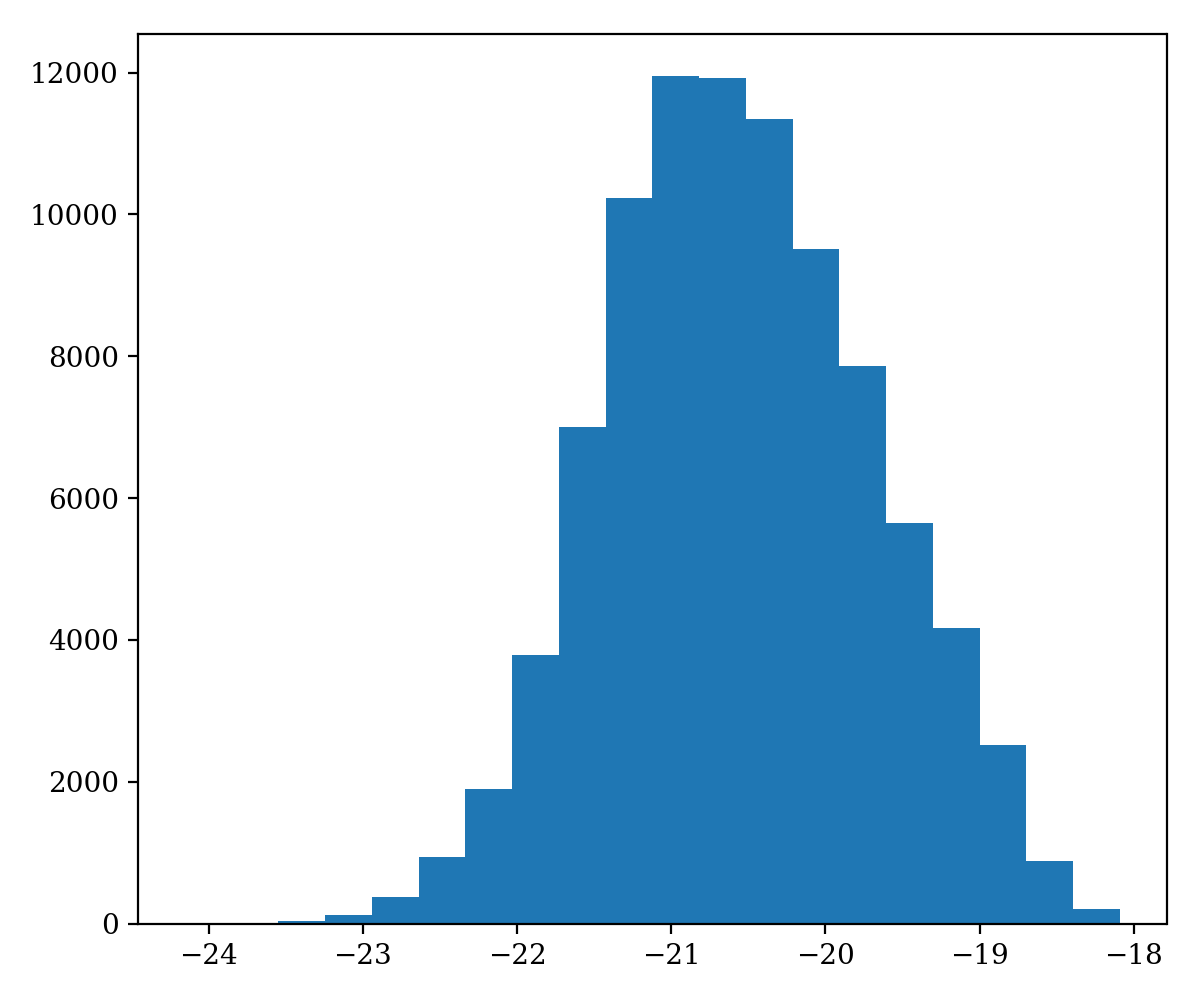

<IPython.core.display.Javascript object>


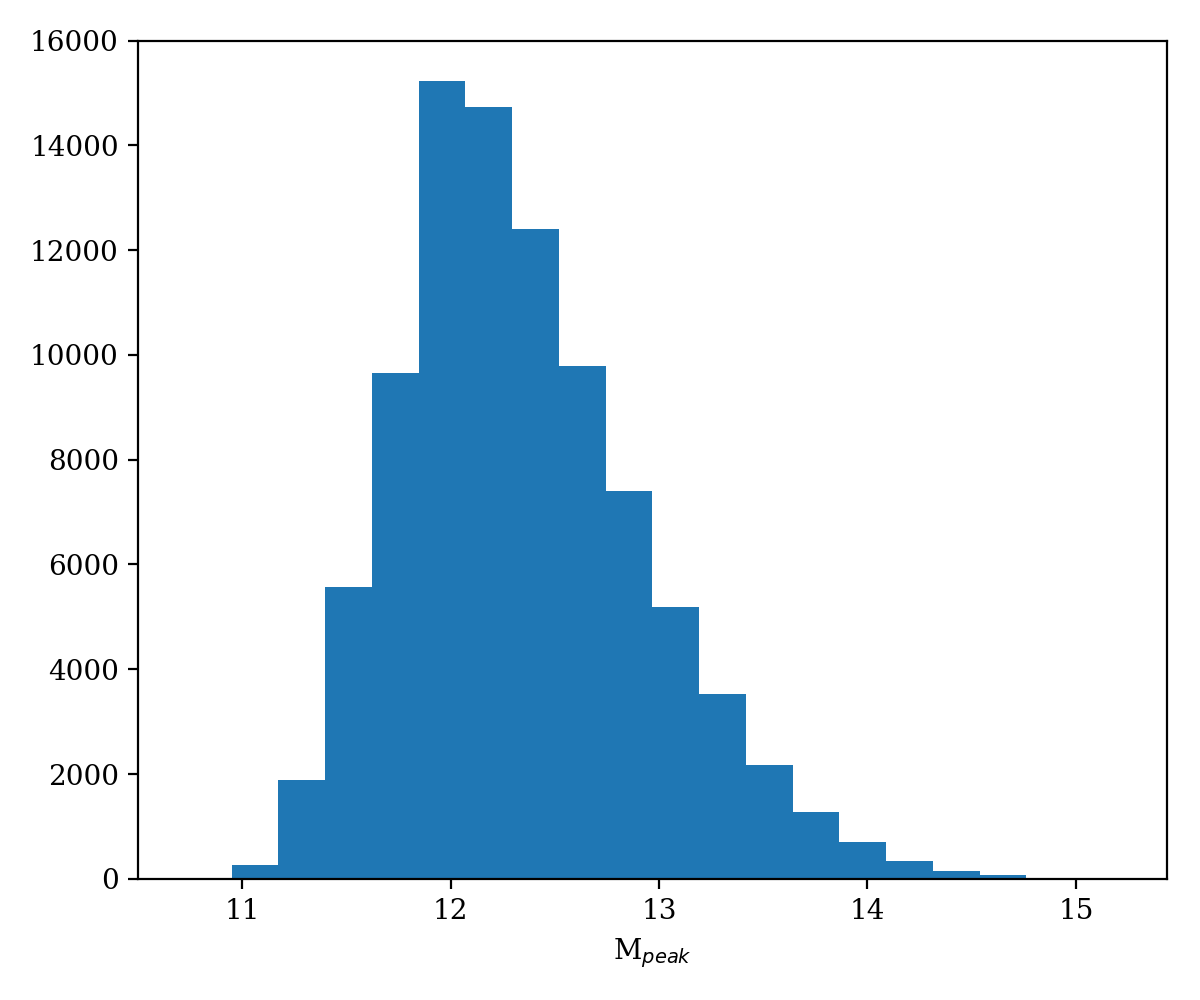

<IPython.core.display.Javascript object>


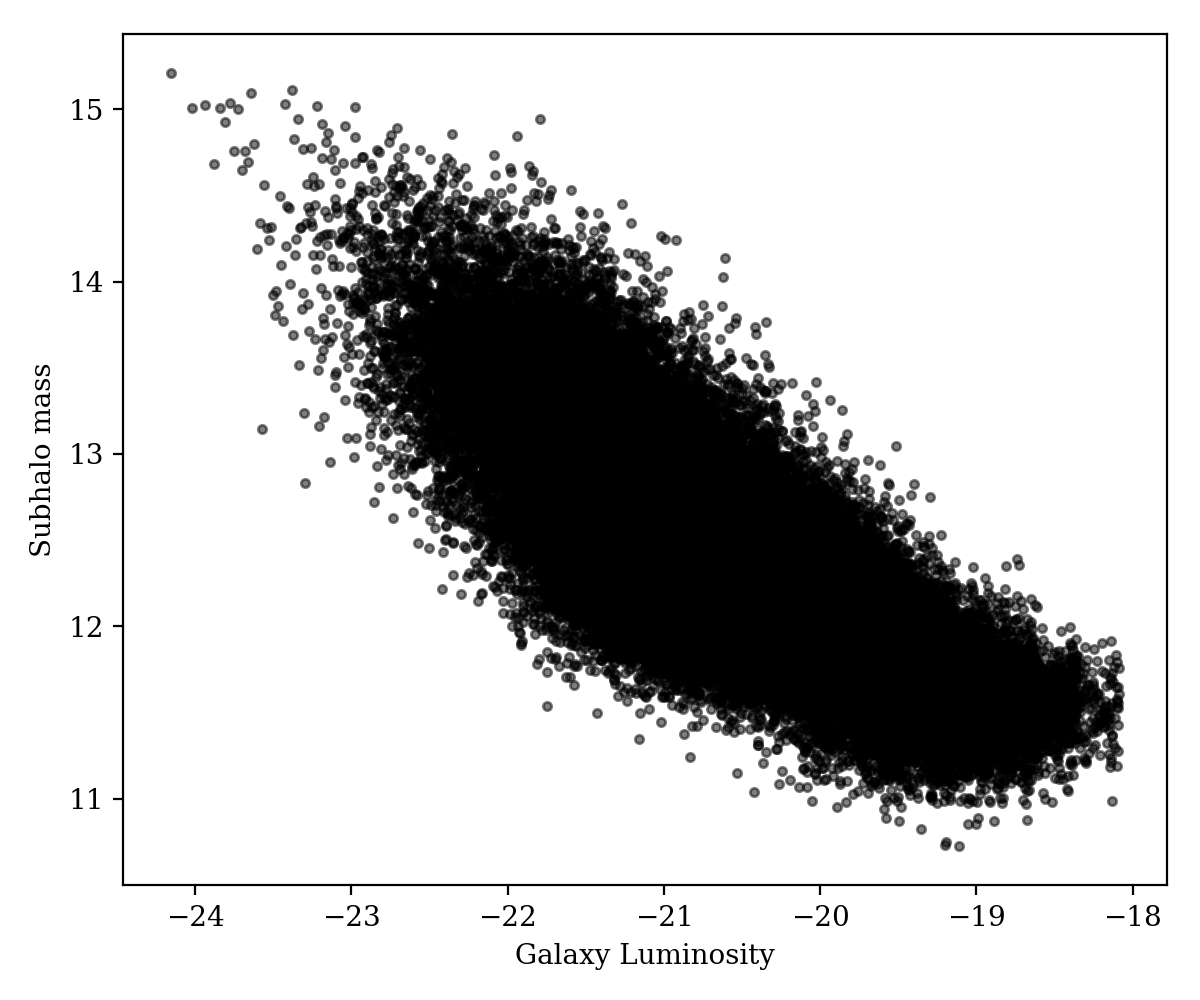

<IPython.core.display.Javascript object>


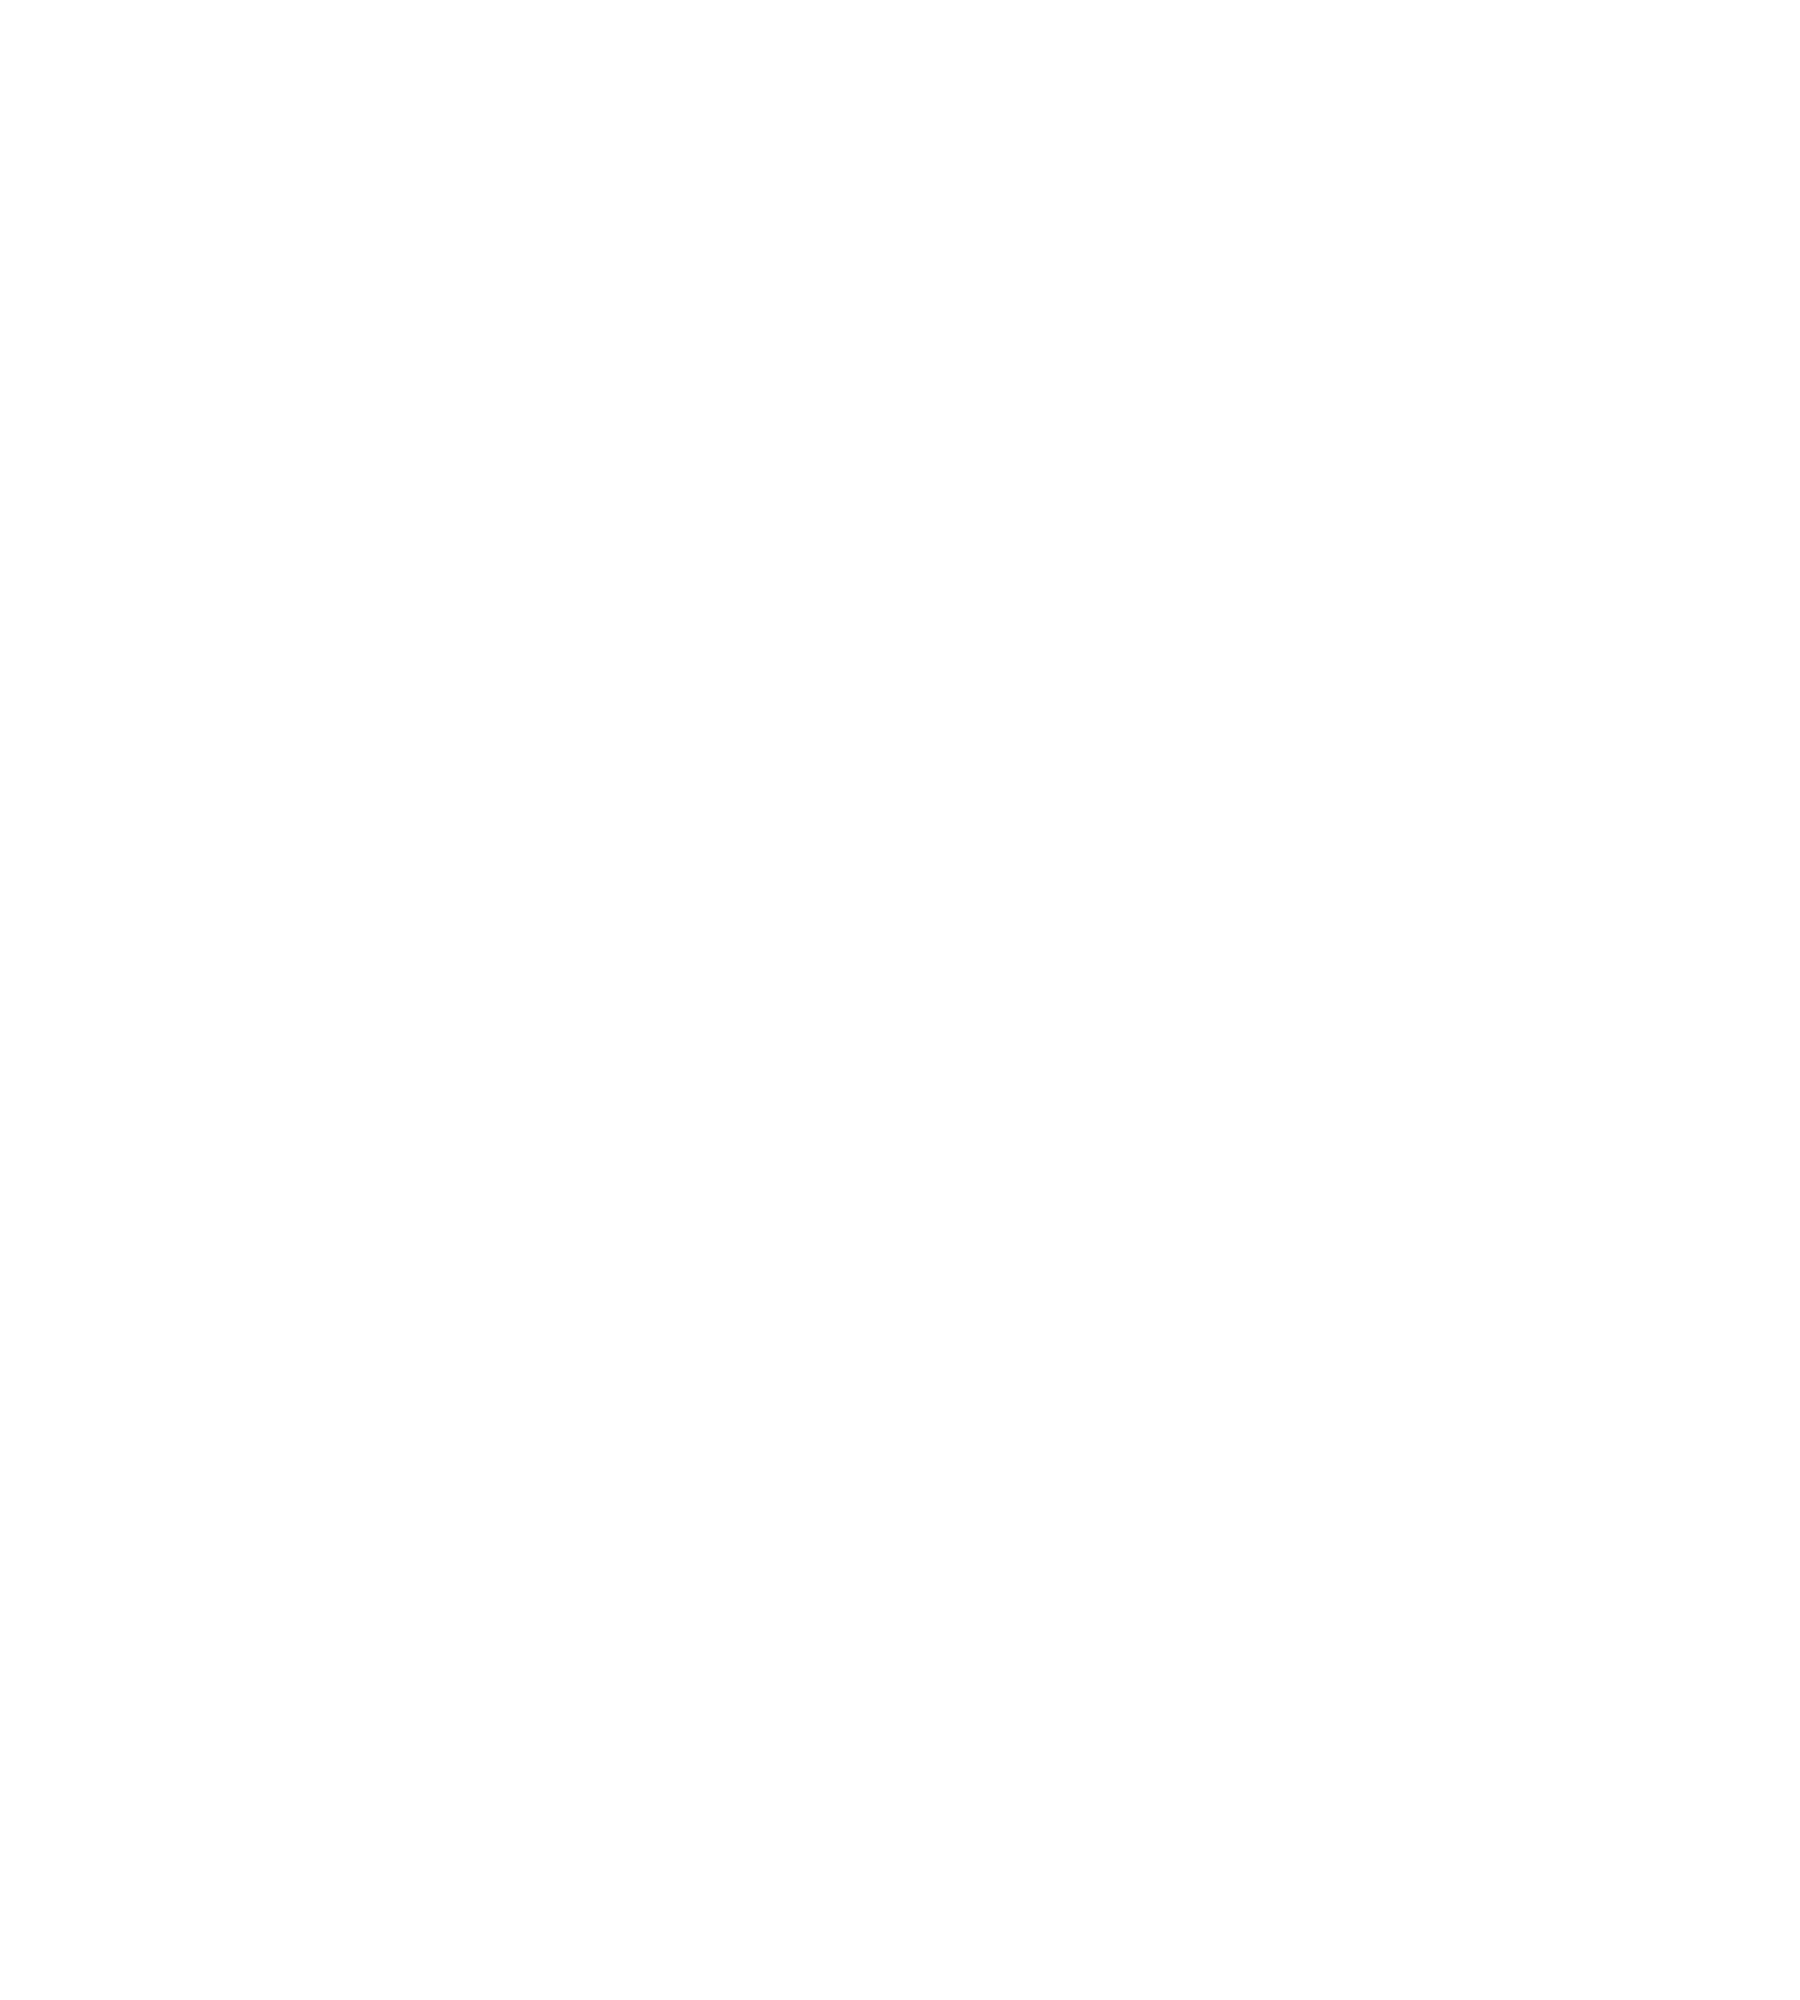

<IPython.core.display.Javascript object>


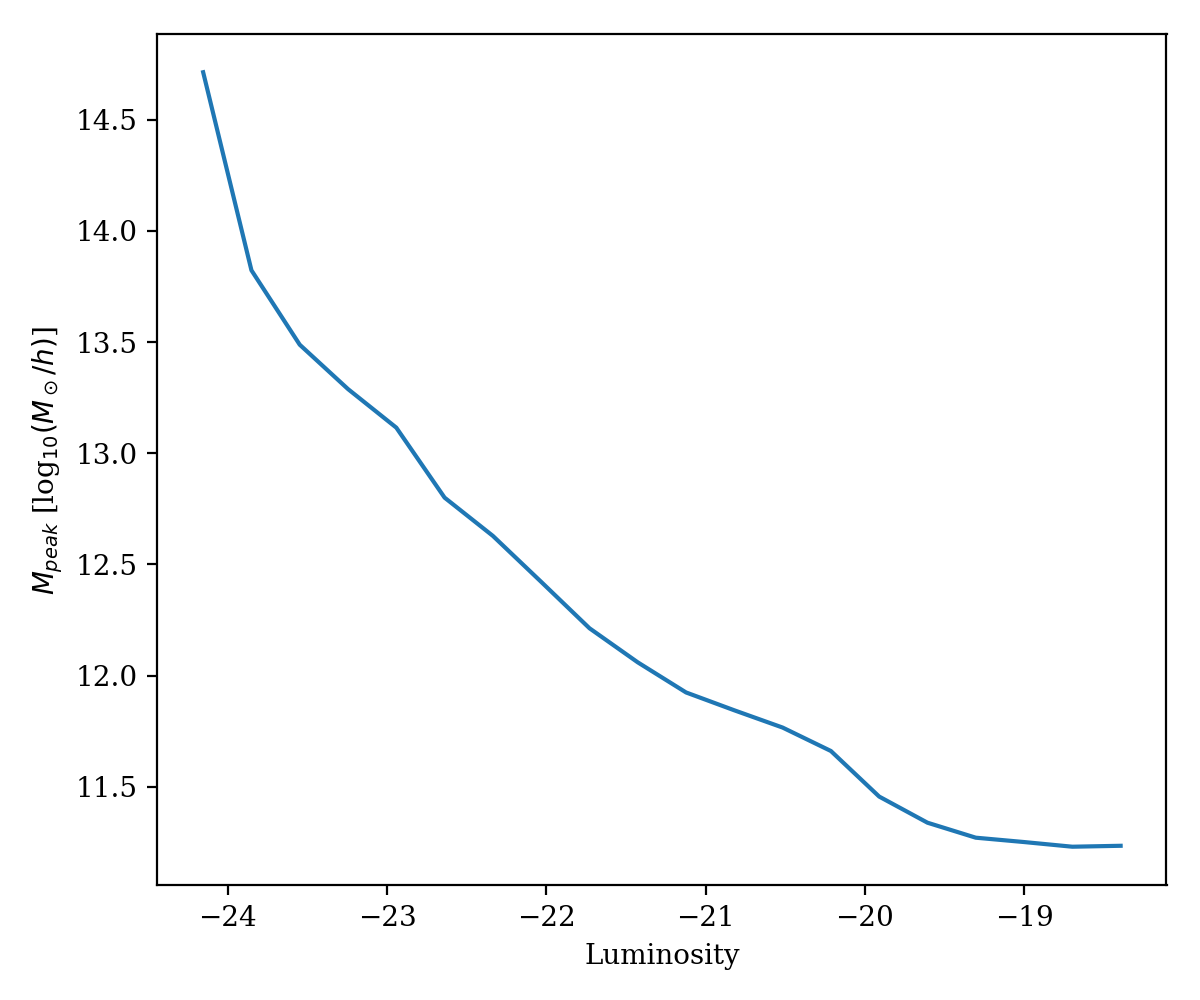

<IPython.core.display.Javascript object>


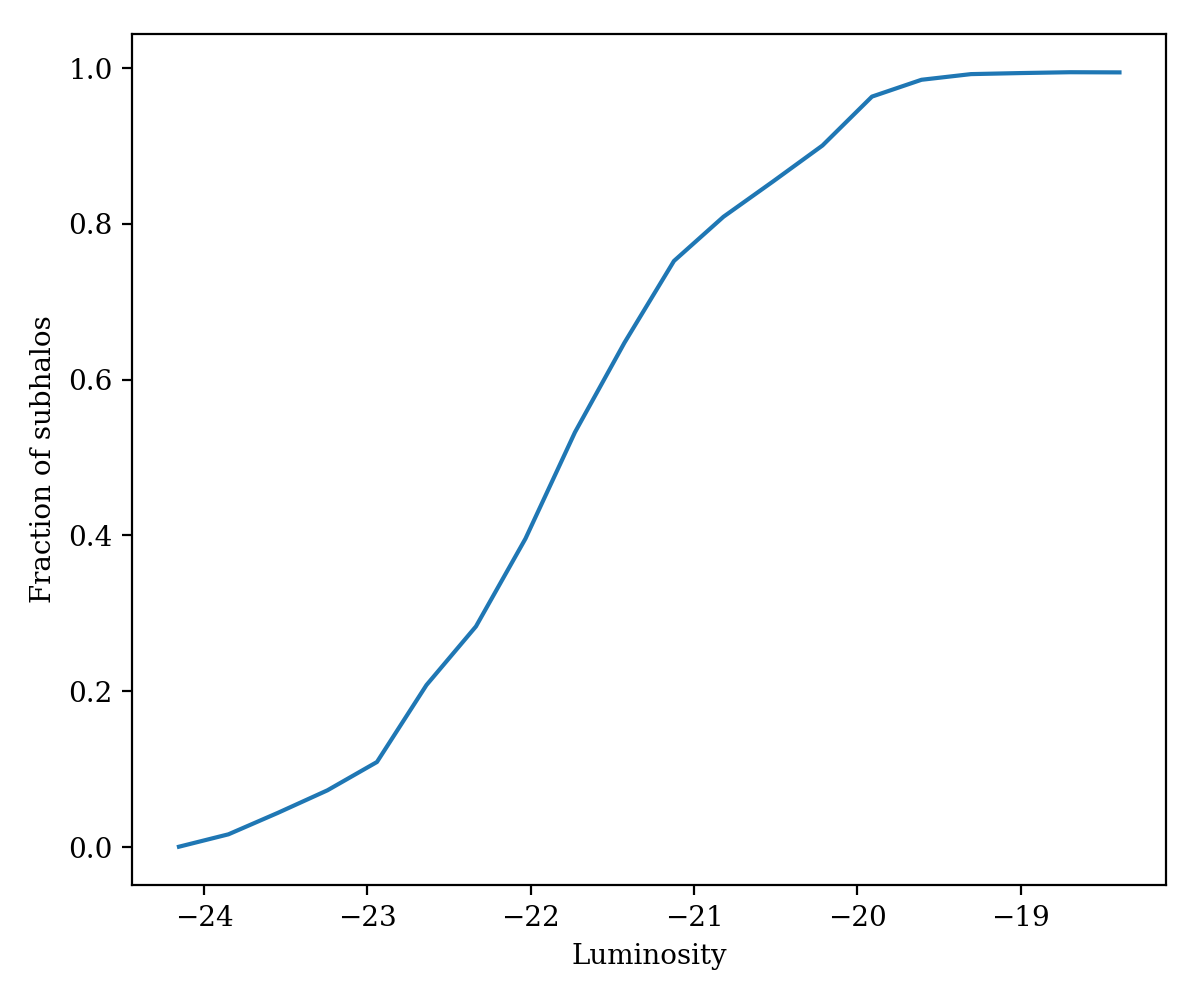

In [108]:
%matplotlib notebook 
# ========== GET THE LUMINOSITIES ==========

# sort based on the index 
# lums = np.asarray(full_catalog[downsampled_idxs_array])


# ====== GET THE MPEAKS FOR ALL OF THE SUBHALOS ======

galaxy_catalog = halocat.halo_table[downsampled_idxs_array]
lums = full_catalog[downsampled_idxs_array]

# get only the subhalos (pId != -1)
pId_cut = np.where(galaxy_catalog["halo_upid"] != -1)[0]

lums_cut = lums
mpeak_cut = np.log10(galaxy_catalog["halo_Mpeak"])

# ======== BIN BY LUMINOSITY ===========
# plt.figure()
n, lumbins, patches = plt.hist(lums_cut, bins = 20)
# plt.xlabel("Luminosity")
plt.savefig("/Users/eniaxhakaj/Desktop/lum_hist.jpg")

plt.figure()
n, mpeakbins, patches = plt.hist(mpeak_cut, bins = 20)
plt.xlabel(r"M$_{peak}$")
plt.savefig("/Users/eniaxhakaj/Desktop/mpeak_hist.jpg")

plt.figure()
plt.scatter(lums_cut, mpeak_cut, color = "k", marker = ".", alpha = .5)
plt.xlabel("Galaxy Luminosity")
plt.ylabel("Subhalo mass")
plt.savefig("/Users/eniaxhakaj/Desktop/scatter.jpg")

mpeak_95s = []
fracs = []
errors = []
# plt.figure()
# plt.scatter(lums_cut, mpeak_sbh, marker = ".")

plt.figure(figsize = (9, 10))

for ibin, bins in enumerate(lumbins):
    
    if ibin == len(lumbins)-1: 
        break
    # get the index bins 
    idx_bin = np.where((lums_cut>bins) & (lums_cut<lumbins[ibin+1]))[0]
    
    # get all the mpeaks in the bin
    mpeak_subsamp = mpeak_cut[idx_bin]
    
    # get the 95th percentile 
    mpeak_95 = np.percentile(mpeak_subsamp, 5)
    
    frac = len(np.where(mpeak_95<mpeak_cut)[0])/len(mpeak_cut)
    
    mpeak_95s.append(mpeak_95)
    fracs.append(frac)
    errors.append(np.std(mpeak_subsamp))
    
#     plt.subplot(5, 4, ibin+1)
#     plt.title(r"[%.2f,%.2f]" %(bins, lumbins[ibin+1]) )
#     plt.hist(mpeak_subsamp, bins = 20, cumulative = True)
#     plt.axvline(x= np.percentile(mpeak_subsamp, 95), color = "k", linestyle = "--")
#     plt.axvline(x= np.percentile(mpeak_subsamp, 5), color = "r", linestyle = "--")
# plt.tight_layout()
# plt.savefig("/Users/eniaxhakaj/Desktop/each_bin.pdf")
#     plt.figure()
#     plt.hist(mpeak_subsamp, bins = 10)
#     plt.axvline(mpeak_95, "k")
    
plt.figure()
plt.plot(lumbins[:-1], mpeak_95s)
plt.xlabel("Luminosity")
plt.ylabel(r"$M_{peak} $ [log$_{10}(M_\odot/h)$] ")
plt.savefig("/Users/eniaxhakaj/Desktop/lum_subhalo_plot_95.pdf")
plt.figure()
plt.plot(lumbins[:-1], fracs)
plt.xlabel("Luminosity")
plt.ylabel(r"Fraction of subhalos")
plt.savefig("/Users/eniaxhakaj/Desktop/lum_frac_plot.pdf")

In [88]:
mpeak_subsamp

<Column name='halo_Mpeak' dtype='float64' length=0>

In [32]:
downsampled_idxs_cut.shape

NameError: name 'downsampled_idxs_cut' is not defined

In [ ]:
b3 = [val for val in lum_sorted if val in downsampled_idxs_cut]

In [ ]:
np.isnan(lum_sorted)

In [ ]:
import numpy as np
a = np.array([1,2,3,4,5])
p = np.percentile(a, 5) # return 50th percentile, e.g median.
print (p)

In [ ]:
print (np.amax(halocat.halo_table["halo_x"]))

In [99]:
lumbins

array([-24.15404953, -24.00247037, -23.8508912 , -23.69931203,
       -23.54773287, -23.3961537 , -23.24457453, -23.09299537,
       -22.9414162 , -22.78983703, -22.63825787, -22.4866787 ,
       -22.33509953, -22.18352037, -22.0319412 , -21.88036204,
       -21.72878287, -21.5772037 , -21.42562454, -21.27404537,
       -21.1224662 , -20.97088704, -20.81930787, -20.6677287 ,
       -20.51614954, -20.36457037, -20.2129912 , -20.06141204,
       -19.90983287, -19.7582537 , -19.60667454, -19.45509537,
       -19.3035162 , -19.15193704, -19.00035787, -18.8487787 ,
       -18.69719954, -18.54562037, -18.3940412 , -18.24246204,
       -18.09088287])